<a href="https://colab.research.google.com/github/konkuk-gaegul/2nd-Team-Project/blob/main/Feature_Set_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 라이브러리

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
!pip install lightgbm
!pip install xgboost
!pip install eli5 shap catboost
!pip install category_encoders

In [ ]:
import tensorflow as tf

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

# ML
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# ensemble(bagging)
from sklearn.ensemble import ( 
  BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
)

#ensemble(boosting)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

#stacking
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier, StackingRegressor

# 평가
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report

# 교차검증
from sklearn.model_selection import (
  KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, train_test_split
)

# Feature Selection
from sklearn.feature_selection import RFE, RFECV

# 시각화(SVM은 회귀계수가 나오지 않습니다.)
import eli5
from eli5.sklearn import PermutationImportance
import shap

# 트리 시각화
import graphviz

# 인코딩
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# feature_set - 3

In [ ]:
train_path = '/content/drive/MyDrive/data/credit/rawData/train.csv'
test_path = '/content/drive/MyDrive/data/credit/rawData/test.csv'

# 정리
- feature set 2 전처리 경우는 사용자의 능력 및 가정환경에 집중했다.
- 이번 feature set 3 전처리는 EDA를 통해 다른 관점으로 바라보았다.
    - 첫 째, 나이대(DAYS_BIRTH, DAYS_EMPLOYED 등)에 따라 타겟변수의 분포가 적은 것을 확인했다.
    - 둘 째, 소득(income_total) 또한 분포가 적은 것을 확인하고, 가중치를 부여했다.
        - 제곱, 로그
        - 파생변수
- 파생변수 다수 생성 및 구간화 적용

# EDA
- 자료의 분포
- Numerical EDA

## 자료의 분포
- 0.9 이상을 높은 연관성을 갖는다고 간주
    - income_total & income_total_log
    - DAYS_BIRTH & DAYS_cubic
- 연관계수가 높은 변수들은 적당히 변환 및 제거된 듯 하다.

In [ ]:
def makeCorr(x, width=25, height=12):
  plt.figure( figsize=(width, height) )
  mask = np.zeros_like(x.corr(), dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(x.corr(), annot=True, fmt='.2f', mask=mask, cmap='YlOrBr')
  plt.show()

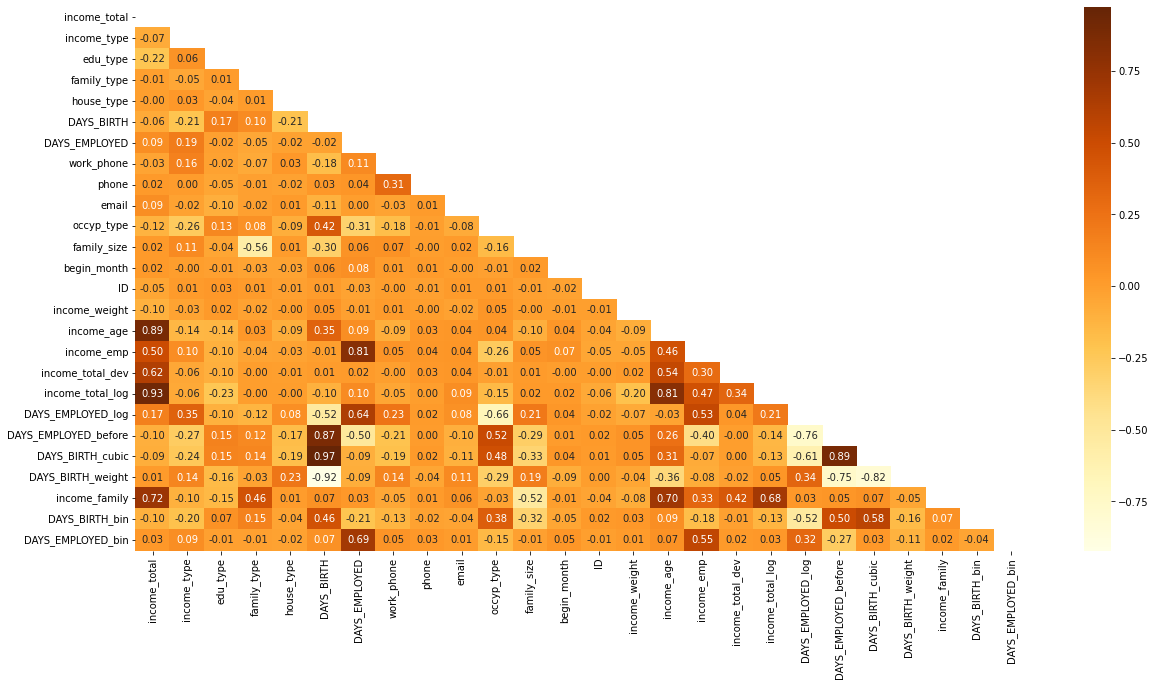

In [ ]:
makeCorr( train.drop(columns=[ 'credit' ,  'car', 'reality', 'gender' ]), width=20, height=10 )

## 2. Numerical EDA

In [ ]:
train_0 = train[ train.credit == 0.0 ]
train_1 = train[ train.credit == 1.0 ]
train_2 = train[ train.credit == 2.0 ]

In [ ]:
# Numerical 그래프 함수 정의
def num_plot(column):
  
  fig, axes = plt.subplots(1, 3, figsize=(16, 6))


  sns.distplot(train_0[column],
                ax = axes[0])
  axes[0].tick_params(labelsize=12)
  axes[0].set_title('credit = 0')
  axes[0].set_ylabel('count')

  sns.distplot(train_1[column],
                ax = axes[1])
  axes[1].tick_params(labelsize=12)
  axes[1].set_title('credit = 1')
  axes[1].set_ylabel('count')

  sns.distplot(train_2[column],
                ax = axes[2])
  axes[2].tick_params(labelsize=12)
  axes[2].set_title('credit = 2')
  axes[2].set_ylabel('count')
    
  plt.subplots_adjust(wspace=0.3, hspace=0.3)

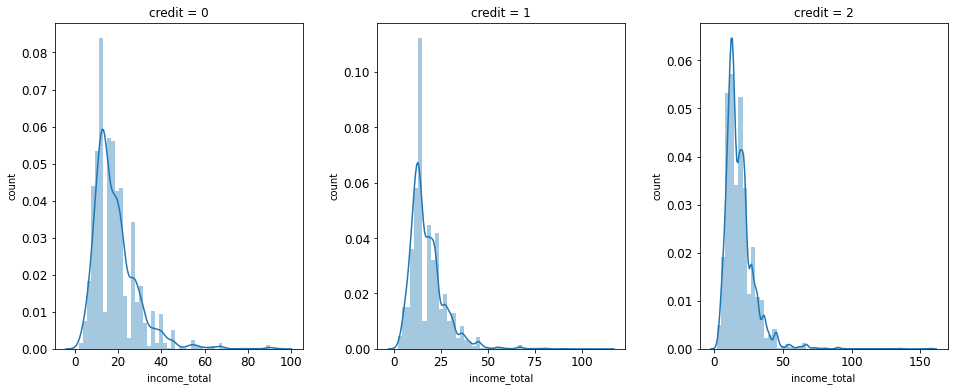

In [ ]:
num_plot("income_total")

- 꼬리가 오른쪽으로 긴 분포
- 타겟 변수별로 분산이 적은 모양을 띈다.
- income_total에 가중치를 줘야겠다
    - 제곱
    - 다른 변수와의 파생변수 등

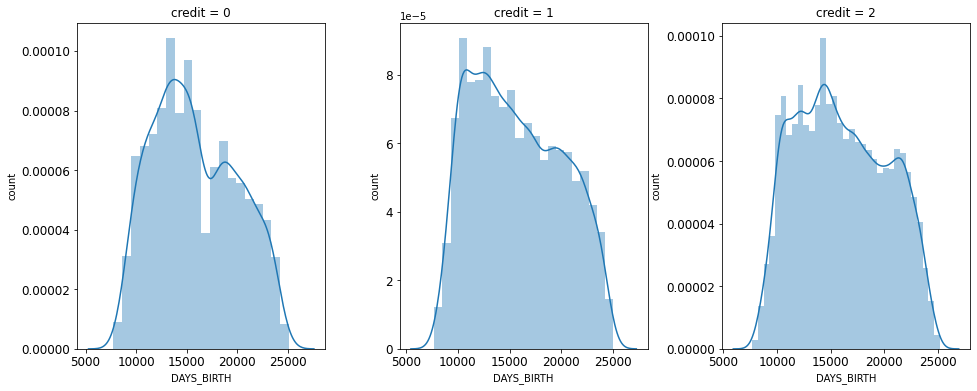

In [ ]:
num_plot('DAYS_BIRTH')

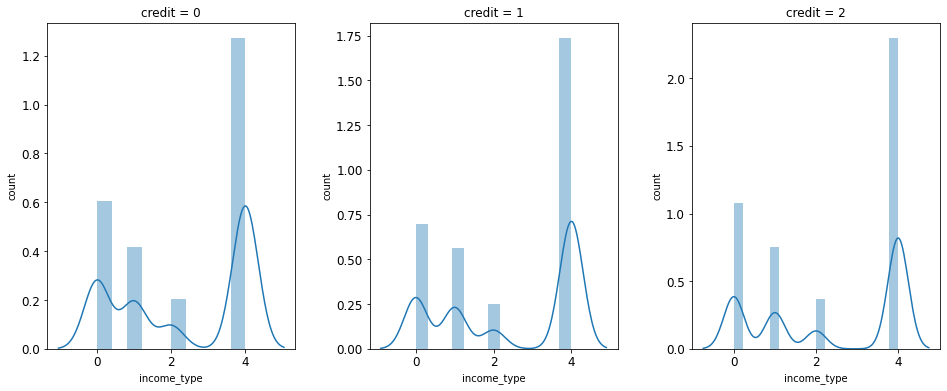

In [ ]:
num_plot('income_type')

# 전처리

## 전처리에 이용되는 함수

In [ ]:
# day를 year로 변경해주는 함수
def days_to_year(x):
    return (x*-1)/365

# 마이너스 변환
def minus(x):
    return x * -1

## 파생변수, 가중치, 전처리

In [ ]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
def numeric(df):

# 1. 의미없는 변수 제거 : index, FLAG_MOBIL, child_num
    df.drop(['index', 'FLAG_MOBIL', 'child_num'], axis=1, inplace = True)

# 2. 이상치 처리
    # 가족수 9명 이상, 6개 자료 삭제 및 인덱스 재설정 
    df = df[ ( df['family_size'] <= 7 ) ]
    df = df.reset_index(drop=True)

# 3. 결측치 처리
    # 첫 째, 결측치 & 근무일이 양수 & 연금수령자 인 경우 retiree(퇴직자)
    # 둘 째, 결측치 & 근무일이 음수인 경우 다양한 income_type 분포로 인해 No response처리
    df.loc[ (df.occyp_type.isna() == True) & (df.DAYS_EMPLOYED > 0) & (df.income_type == 'Pensioner') , 'occyp_type' ] = 'retiree'
    df['DAYS_EMPLOYED'] = df[ 'DAYS_EMPLOYED' ].map(lambda x: 0 if x>0 else x)
    df.occyp_type.fillna('No response', inplace=True) 

# 4. log 사용
    # 음수자료를 양수로 변환
    feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
    for feat in feats:
        df[feat] = np.abs(df[feat])
        
    # df['income_total'] = np.log1p(1+df['income_total'])
    # df['DAYS_EMPLOYED'] = np.log1p(1+df['DAYS_EMPLOYED'])
    # df['DAYS_BIRTH'] = np.log1p(1+df['DAYS_BIRTH'])
    # df['begin_month'] = np.log1p(1+df['begin_month'])

# 5. 새로운 변수 ID열 생성 : 한 사람이 다수의 카드를 발급 받았을 경우
    df['ID'] = \
    df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

# 6. 라벨 인코딩 (categorical 변수를 numerical로 변환!!)
    df['gender']=LabelEncoder().fit_transform(df.gender)
    df['car']=LabelEncoder().fit_transform(df.car)
    df['reality']=LabelEncoder().fit_transform(df.reality)
    df['income_type']=LabelEncoder().fit_transform(df.income_type)
    df['edu_type']=LabelEncoder().fit_transform(df.edu_type)
    df['family_type']=LabelEncoder().fit_transform(df.family_type)
    df['house_type']=LabelEncoder().fit_transform(df.house_type)
    df['occyp_type']=LabelEncoder().fit_transform(df.occyp_type)

# 7. income_total 가중치 (numerical EDA 참조)
    df['income_weight']=df.income_total**2
    df['income_age']=df.income_total*df.DAYS_BIRTH
    df['income_emp']=df.income_total*df.DAYS_EMPLOYED
    df['income_total'] = df['income_total']/10000
    df['income_total_dev'] = (df['income_total'] - df['income_total'].mean())**2 # 편차제곱
    df['income_total_log'] = df['income_total'].apply(np.log1p)                  # 로그변환

# 8. DAYS_EMPLOYED 가중치
    df['DAYS_EMPLOYED_log'] = df['DAYS_EMPLOYED'].apply(np.log1p) # 로그 변환
    df['DAYS_EMPLOYED_before'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED'] # 로그 변환
    # df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(days_to_year) # days를 years로 변환
    
# 9. type 변환
    df.income_total = df.income_total.astype(int)
    df.family_size = df.family_size.astype(int)
    df.begin_month = df.begin_month.astype(int)

# 10. 파생변수
    df['income_weight'] = 1/(df.income_weight)**3
    df['DAYS_BIRTH_cubic'] = df.DAYS_BIRTH**3
    df['DAYS_BIRTH_weight'] = 1/(df.DAYS_BIRTH)**2
    df['income_family'] = df.income_total / df.family_size
    return df
# ------------------------------------------------------------------- #

In [ ]:
train = numeric(train)
test  = numeric(test)

In [ ]:
train.head(2)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,...,income_weight,income_age,income_emp,income_total_dev,income_total_log,DAYS_EMPLOYED_log,DAYS_EMPLOYED_before,DAYS_BIRTH_cubic,DAYS_BIRTH_weight,income_family
0,0,0,0,20,0,1,1,2,13899,4709,...,1.450273e-32,2.814548e+09,953572500.0,2.308172,3.056357,8.457443,9190,2685039411699,5.176460e-09,10.0
1,0,0,1,24,0,4,0,1,11380,1540,...,4.350596e-33,2.816550e+09,381150000.0,36.231574,3.248435,7.340187,9840,1473760072000,7.721745e-09,8.0


## 구간화

In [ ]:
#구간화 함수
def make_bin(df, variable, n):
    
    data = df
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable] = pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]
    print(data['%s_bin' % variable], '\n\n')
    
    return data

# days_birth 구간화
train = make_bin(train, 'DAYS_BIRTH', n=10)
test = make_bin(test, 'DAYS_BIRTH', n=10)

# days_employed 구간화
train = make_bin(train, 'DAYS_EMPLOYED', n=10)
test = make_bin(test, 'DAYS_EMPLOYED', n=10)

# catboost는 categorical로 두면 안 됨
cat_credit=train.credit.astype('int').copy()
train.credit=train.credit.astype('category')

0        0
1        1
2        2
3        3
4        3
        ..
26446    1
26447    3
26448    5
26449    5
26450    2
Name: DAYS_BIRTH_bin, Length: 26451, dtype: int64 


0       0
1       1
2       2
3       1
4       3
       ..
9995    1
9996    8
9997    4
9998    3
9999    9
Name: DAYS_BIRTH_bin, Length: 10000, dtype: int64 


0        0
1        1
2        0
3        2
4        2
        ..
26446    2
26447    2
26448    2
26449    1
26450    1
Name: DAYS_EMPLOYED_bin, Length: 26451, dtype: int64 


0       0
1       1
2       0
3       2
4       1
       ..
9995    4
9996    0
9997    8
9998    0
9999    0
Name: DAYS_EMPLOYED_bin, Length: 10000, dtype: int64 




## 인코딩

In [ ]:
# ID 인코딩
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  29
Number of Categorical features:  0


In [ ]:
numerical_feats

['gender',
 'car',
 'reality',
 'income_total',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'occyp_type',
 'family_size',
 'begin_month',
 'income_weight',
 'income_age',
 'income_emp',
 'income_total_dev',
 'income_total_log',
 'DAYS_EMPLOYED_log',
 'DAYS_EMPLOYED_before',
 'DAYS_BIRTH_cubic',
 'DAYS_BIRTH_weight',
 'income_family',
 'DAYS_BIRTH_bin',
 'DAYS_EMPLOYED_bin']

In [ ]:
categorical_feats

['ID']

In [ ]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

# feature_set_3 저장

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
pd.DataFrame( train ).to_csv('/content/drive/MyDrive/data/credit/feature_set_3/train_3.csv', index=False)
pd.DataFrame( test ).to_csv('/content/drive/MyDrive/data/credit/feature_set_3/test_3.csv', index=False)

# 모델링-1 (CatBoost)
- Clustering과 Scaling 없이 진행한다.
- CrossValidation Parameter
    - n_folds를 10과 15로 나누어 진행한다.

In [ ]:
train_path = '/content/drive/MyDrive/data/credit/feature_set_3/train_3.csv'
test_path = '/content/drive/MyDrive/data/credit/feature_set_3/test_3.csv'

In [ ]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [ ]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID,income_weight,income_age,income_emp,income_total_dev,income_total_log,DAYS_EMPLOYED_log,DAYS_EMPLOYED_before,DAYS_BIRTH_cubic,DAYS_BIRTH_weight,income_family,DAYS_BIRTH_bin,DAYS_EMPLOYED_bin
0,0,0,0,20,0,1,1,2,13899,4709,0,0,0,12,2,6,1.0,1,1.450273e-32,2.814548e+09,9.535725e+08,2.308172,3.056357,8.457443,9190,2685039411699,5.176460e-09,10.0,0,0
1,0,0,1,24,0,4,0,1,11380,1540,0,0,1,8,3,5,1.0,2,4.350596e-33,2.816550e+09,3.811500e+08,36.231574,3.248435,7.340187,9840,1473760072000,7.721745e-09,8.0,1,1
2,1,1,1,45,4,1,1,1,19087,4434,0,1,0,10,2,22,2.0,3,1.204273e-34,8.589150e+09,1.995300e+09,690.074382,3.828641,8.397283,14653,6953653091503,2.744888e-09,22.5,2,0
3,0,0,1,20,0,4,1,1,15088,2092,0,1,0,15,2,37,0.0,4,1.450273e-32,3.055320e+09,4.236300e+08,2.308172,3.056357,7.646354,12996,3434749161472,4.392752e-09,10.0,3,2
4,0,1,1,15,2,1,1,1,15037,2105,0,0,0,10,2,26,2.0,5,6.551137e-32,2.368328e+09,3.315375e+08,8.884770,2.818398,7.652546,12932,3400036655653,4.422599e-09,7.5,3,2


In [ ]:
train.shape, test.shape

((26451, 30), (10000, 29))

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

In [ ]:
# one of the parameters : cat_features
categorical_feats

['ID']

## n_fold = 10
- Log Loss: 0.668709

In [ ]:
n_est = 2000
seed = 42
n_fold = 10
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')





----------------- Fold 0 -----------------

Learning rate set to 0.115043
0:	learn: 1.0358760	test: 1.0343382	best: 1.0343382 (0)	total: 228ms	remaining: 3m 48s
100:	learn: 0.7067372	test: 0.6589122	best: 0.6589122 (100)	total: 16.6s	remaining: 2m 27s
200:	learn: 0.6882969	test: 0.6564202	best: 0.6563252 (175)	total: 29.1s	remaining: 1m 55s
300:	learn: 0.6720172	test: 0.6565387	best: 0.6561792 (261)	total: 43s	remaining: 1m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6561791751
bestIteration = 261

Shrink model to first 262 iterations.
CV Log Loss Score: 0.656179

----------------- Fold 1 -----------------

Learning rate set to 0.115043
0:	learn: 1.0339885	test: 1.0345593	best: 1.0345593 (0)	total: 139ms	remaining: 2m 19s
100:	learn: 0.7096889	test: 0.6587712	best: 0.6587712 (100)	total: 11.1s	remaining: 1m 38s
200:	learn: 0.6906049	test: 0.6569518	best: 0.6567442 (187)	total: 24.9s	remaining: 1m 39s
300:	learn: 0.6747758	test: 0.6583372	best: 0.6566172 (2

### Feature Importance

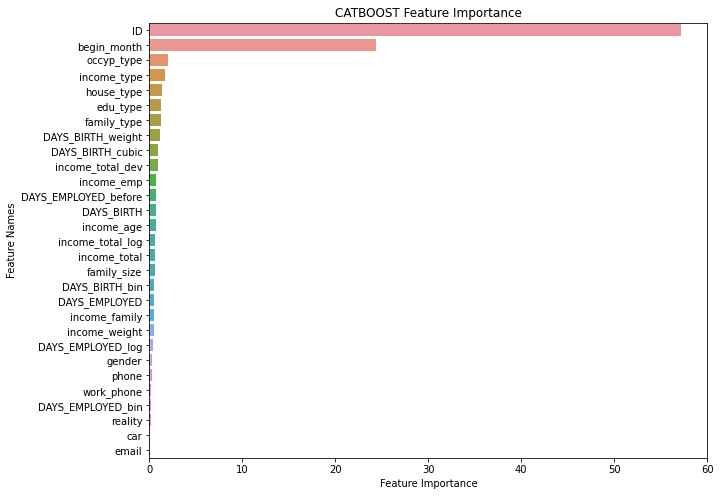

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

- ID의 설명력이 갈 수록 높아진다.
- 파생변수의 설명력
    - DAYS_BIRTH
        - weight / cubic
    - income_total
        - income_total_dev / income_emp / income_age
    - DAYS_EMPLOYED
        - before

## n_fold = 15
- Log Loss: 0.664093

In [ ]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
log_loss_avg = []

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')





----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0356057	test: 1.0341413	best: 1.0341413 (0)	total: 136ms	remaining: 2m 15s
100:	learn: 0.7058240	test: 0.6422354	best: 0.6421789 (99)	total: 15s	remaining: 2m 13s
200:	learn: 0.6874758	test: 0.6398888	best: 0.6398619 (189)	total: 27.8s	remaining: 1m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6398618659
bestIteration = 189

Shrink model to first 190 iterations.
CV Log Loss Score: 0.639862

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0356100	test: 1.0349051	best: 1.0349051 (0)	total: 145ms	remaining: 2m 25s
100:	learn: 0.7048109	test: 0.6734143	best: 0.6734143 (100)	total: 11.2s	remaining: 1m 39s
200:	learn: 0.6868747	test: 0.6714541	best: 0.6710867 (198)	total: 23.7s	remaining: 1m 34s
300:	learn: 0.6703758	test: 0.6710550	best: 0.6705161 (280)	total: 36.3s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

b

### Feature Importance

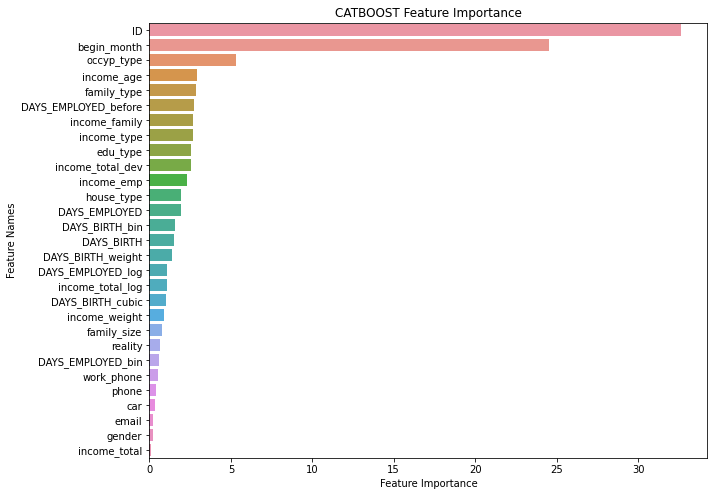

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

- n_fold가 10인 경우보다 ID 변수 설명력이 작아졌다.

# 모델링-2 (CatBoost)
- 설명력이 부족했던 변수를 제거
- 클러스터링 / 정규화 진행
- CrossValidation Parameter
    - n_folds를 10과 15로 나누어 진행한다.

In [ ]:
# 설명력이 부족한 변수를 제거해보자
col = ['income_total', 'work_phone', 'email', 'DAYS_EMPLOYED_bin']
for df in [train, test]:
    df.drop(columns=col, inplace=True)
    

### 클러스터링
- 36개의 군집으로 나누어본다.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

In [ ]:
train['cluster'].value_counts()

23    1746
14    1455
25    1420
19    1364
11    1350
1     1314
12    1046
20    1035
6     1011
5      985
34     915
21     869
27     827
9      825
15     808
2      711
16     655
28     621
3      582
10     546
18     545
31     540
35     540
33     539
0      537
8      526
22     500
17     476
29     407
7      365
32     360
24     297
13     281
4      195
26     167
30      91
Name: cluster, dtype: int64

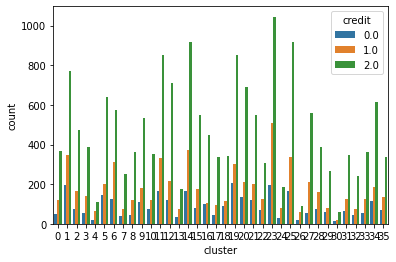

In [ ]:
sns.countplot(data=train, x='cluster', hue='credit')

### StandardScale
- 평균 1, 분산 0 : N(1,0)으로 만들어준다.
- 이미 로그변환을 마친 컬럼 제외
- income_total, DAYS_EMOPLOYED, DAYS_BIRTH, begin_month

In [ ]:
from sklearn.preprocessing import StandardScaler
import multiprocessing

In [ ]:
cat_col = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID',
            'DAYS_EMPLOYED_log', 'income_total_log', 'income_total', 'work_phone', 'email',
            'DAYS_EMPLOYED_bin' ]

In [ ]:
for feat in cat_col:
    numerical_feats.remove(feat)

scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

### n_fold = 10
- Log Loss: 0.669396

In [ ]:
n_est = 2000
seed = 42
n_fold = 10
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
log_loss_avg = []

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')





----------------- Fold 0 -----------------

Learning rate set to 0.115043
0:	learn: 1.0358741	test: 1.0342023	best: 1.0342023 (0)	total: 300ms	remaining: 4m 59s
100:	learn: 0.7059414	test: 0.6589508	best: 0.6589181 (96)	total: 12s	remaining: 1m 46s
200:	learn: 0.6860390	test: 0.6577139	best: 0.6572876 (147)	total: 24.5s	remaining: 1m 37s
300:	learn: 0.6677530	test: 0.6564003	best: 0.6562299 (297)	total: 38s	remaining: 1m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6562298762
bestIteration = 297

Shrink model to first 298 iterations.
CV Log Loss Score: 0.656230

----------------- Fold 1 -----------------

Learning rate set to 0.115043
0:	learn: 1.0378588	test: 1.0390255	best: 1.0390255 (0)	total: 98.1ms	remaining: 1m 37s
100:	learn: 0.7081581	test: 0.6613689	best: 0.6612743 (90)	total: 11.5s	remaining: 1m 42s
200:	learn: 0.6890117	test: 0.6593983	best: 0.6589734 (187)	total: 24.2s	remaining: 1m 36s
300:	learn: 0.6704032	test: 0.6602036	best: 0.6586399 (241)

#### Feature Importance

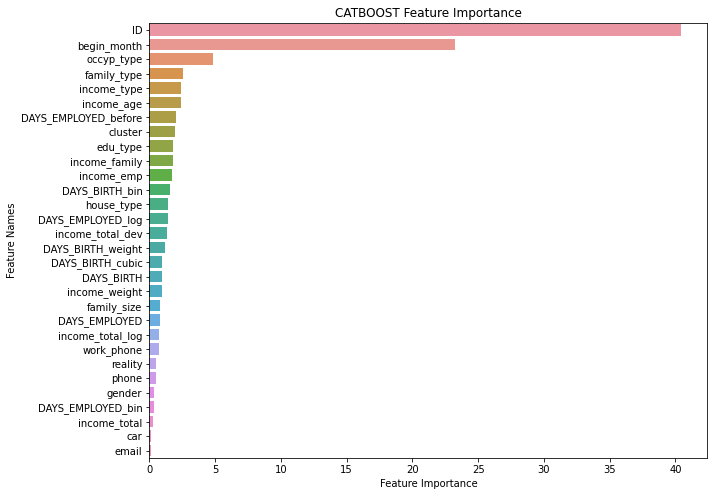

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

### n_fold = 15
- Log Loss : 0.665395

In [ ]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
log_loss_avg = []

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')





----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0348881	test: 1.0336665	best: 1.0336665 (0)	total: 144ms	remaining: 2m 23s
100:	learn: 0.7056921	test: 0.6419577	best: 0.6419425 (95)	total: 11.5s	remaining: 1m 41s
200:	learn: 0.6868178	test: 0.6395174	best: 0.6395174 (200)	total: 30.9s	remaining: 2m 2s
300:	learn: 0.6691743	test: 0.6396400	best: 0.6391660 (275)	total: 45.3s	remaining: 1m 45s
400:	learn: 0.6529950	test: 0.6394316	best: 0.6387545 (381)	total: 58.3s	remaining: 1m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6387544707
bestIteration = 381

Shrink model to first 382 iterations.
CV Log Loss Score: 0.638754

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0347871	test: 1.0340401	best: 1.0340401 (0)	total: 136ms	remaining: 2m 16s
100:	learn: 0.7041998	test: 0.6733554	best: 0.6731291 (82)	total: 11.6s	remaining: 1m 43s
200:	learn: 0.6859933	test: 0.6712444	best: 0.6711024 (14

#### Feature Importance

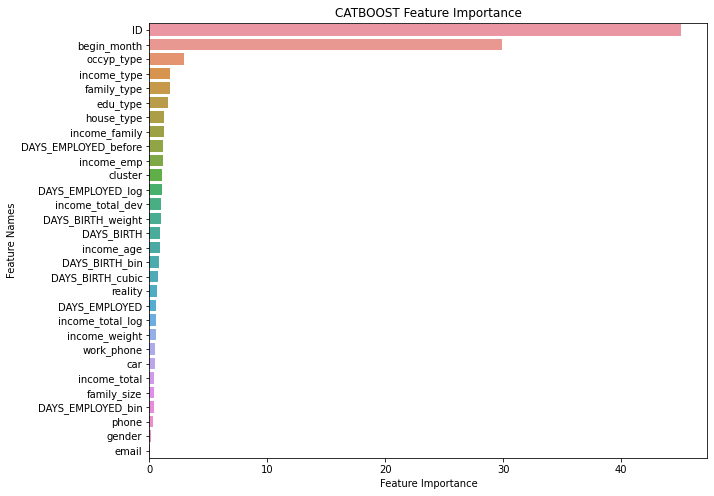

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

# feature_set_3 후기
- occyp_type : 직업분류
    - 직업 분류의 설명력 또한 모든 모델링에서 높이 측정되었다.
    - rawData의 결측치는 이 변수에 몰빵되어 있었다.
    - 결측치의 절반 이상은 income_type과 연관되어 있었고, 정당한 이유로 결측치를 대체했던 것이 높은 설명력의 원인이 된 것 같다.
    

# Submission

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/data/credit/rawData/sample_submission.csv')

In [ ]:
sub.iloc[:, 1:] = cat_pred_test

In [ ]:
sub

,index,0,1,2
0,26457,0.123848,0.158012,0.718140
1,26458,0.353239,0.201522,0.445239
2,26459,0.038361,0.069863,0.891776
3,26460,0.052590,0.085654,0.861756
4,26461,0.082865,0.247818,0.669318
...,...,...,...,...
9995,36452,0.073124,0.222610,0.704266
9996,36453,0.310683,0.188832,0.500485
9997,36454,0.047204,0.109072,0.843724
9998,36455,0.153709,0.302546,0.543745


In [ ]:
sub.to_csv('/content/drive/MyDrive/data/credit/submission/submission_feature_set_3_M1_2_nfold_15.csv', index=False)